# Ridge Regression (gradient descent) from Scratch

In [5]:
import graphlab # Import the libraries
import numpy as np
import pandas as pd

# Load in house sales data

In [4]:
# House Sales Data from King County, Seatle, WA
sales = graphlab.SFrame('kc_house_data.gl/')

In [6]:
def get_numpy_data(df,features,output):
    df['constant']=1 # A new column for the constant/intercept term
    features=['constant']+features # Column Names
    sframe=df[features] # Copy all the data for the selected features in the new dataframe
    smatrix=sframe.to_numpy() # Creating a numpy array for the features
    output_array=np.array(df[output])# Array for the ouptut/target
    return smatrix, output_array

In [7]:
def predict_output(f, w):
    # This fucntion will multiply the features by its weights
    # So if there are D features, a weight is assigned to each feature
    pred_out=np.dot(f,w)
    return pred_out

# Computing the Derivative

The cost function is the sum over the data points of the squared difference between an observed output and a predicted output, plus the L2 penalty term.
```
Cost(w)
= SUM[ (prediction - output)^2 ]
+ l2_penalty*(w[0]^2 + w[1]^2 + ... + w[k]^2).
```

We get
```
2*SUM[ error*[feature_i] ] + 2*l2_penalty*w[i].
```
That is, the derivative for the weight for feature i is the sum (over data points) of 2 times the product of the error and the feature itself, plus `2*l2_penalty*w[i]`. 

In [8]:
def feature_derivative_ridge(errors, feature, weight, l2_penalty, feature_is_constant):
    # If feature_is_constant is True, derivative is twice the dot product of errors and feature
    if feature_is_constant==True:
        derivative=2*np.dot(errors,feature)
    # Otherwise, derivative is twice the dot product plus 2*l2_penalty*weight
    else:
        derivative=2*np.dot(errors,feature) + 2*l2_penalty*weight     
    return derivative

To test your feature derivartive run the following:

In [15]:
# Sample 
(example_features, example_output) = get_numpy_data(sales, ['sqft_living'], 'price') 
my_weights = np.array([1., 10.])
test_predictions = predict_output(example_features, my_weights) 
errors = test_predictions - example_output # prediction errors

# For features it prints out the derivative
print feature_derivative_ridge(errors, example_features[:,1], my_weights[1], 1, False)

# For constant it prints out the derivative
print feature_derivative_ridge(errors, example_features[:,0], my_weights[0], 1, True)


-5.65541667824e+13
-22446749336.0


# Gradient Descent

Given a starting point we update the current weights by moving in the negative gradient direction. Recall that the gradient is the direction of *increase* and therefore the negative gradient is the direction of *decrease* and we're trying to *minimize* a cost function. 

The amount by which we move in the negative gradient *direction*  is called the 'step size'. We stop when we are 'sufficiently close' to the optimum. If no maximum number is supplied, the maximum should be set 100 by default. 

In [26]:
def ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations=100):
    print 'Starting gradient descent with l2_penalty = ' + str(l2_penalty)
    my_weights = np.array(initial_weights) 
    iteration = 0  
    while iteration<=max_iterations:
        iteration += 1  
        predictions=predict_output(feature_matrix,my_weights) # Predict the outcomes
        errors=predictions-output # Calculate the error
        for i in xrange(len(my_weights)):
            if i==0:
                derivative=2*np.dot(errors,feature_matrix[:,i]) # The partial derivative
            else:
                derivative=2*np.dot(errors,feature_matrix[:,i])+2*l2_penalty*my_weights[i] # The partial derivative
            my_weights[i]-=step_size*np.sum(derivative)  # Update the weights
    print 'Done with gradient descent at iteration ', iteration
    print 'Learned weights = ', str(my_weights)
    return my_weights

# Visualizing effect of L2 penalty

The L2 penalty gets its name because it causes weights to have small L2 norms than otherwise. Let's see how large weights get penalized. Let us consider a simple model with 1 feature:

Let us split the dataset into training set and test set. Make sure to use `seed=0`:

In [33]:
train_data,test_data = sales.random_split(.8,seed=0) # Splitting the data

# Simple features 
simple_features = ['sqft_living']
my_output = 'price'
(simple_feature_matrix, output) = get_numpy_data(train_data, simple_features, my_output)
(simple_test_feature_matrix, test_output) = get_numpy_data(test_data, simple_features, my_output)

Let's set the parameters for our optimization:

In [35]:
# Initial parameters
initial_weights = np.array([0., 0.])
step_size = 1e-12 # Step size: constant in this case, we can also have decreasing step size, to avoid overshooting
max_iterations=1000 

#Calling the ridge regression function
simple_weights_0_penalty=ridge_regression_gradient_descent(simple_feature_matrix, output, initial_weights, step_size, 0, 1000-1)
print "Co-efficient of sqft_living is: ",simple_weights_0_penalty[1]

Starting gradient descent with l2_penalty = 0
Done with gradient descent at iteration  1000
Learned weights =  [ -1.63113501e-01   2.63024369e+02]
Co-efficient of sqft_living is:  263.024368907


Next, let's consider high regularization.  Set the `l2_penalty` to `1e11` and run your ridge regression algorithm to learn the weights of our model.

In [36]:
#Initial parameters with high regularization i.e. high penalty causing high weights to be highly penalized
l2=1e11
simple_weights_high_penalty=ridge_regression_gradient_descent(simple_feature_matrix, output, initial_weights, step_size, l2, 1000)
print "Co-efficient of sqft_living is: ",simple_weights_high_penalty[1]

Starting gradient descent with l2_penalty = 1e+11
Done with gradient descent at iteration  1001
Learned weights =  [   9.77704732  124.57217379]
Co-efficient of sqft_living is:  124.572173792


This code will plot the two learned models.  (The blue line is for the model with no regularization and the red line is for the one with high regularization.)

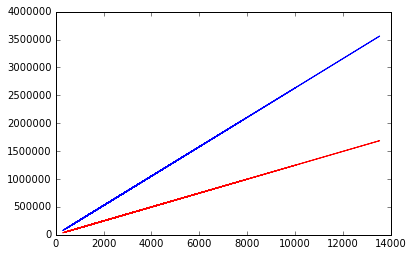

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_0_penalty),'b-',
          simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_high_penalty),'r-')

In [44]:
# Calculate high regulariztaion
a=test_data['sqft_living']

#Price= constant + weight for sqft_living * data[sqft_living]
pred=a*simple_weights_high_penalty[1]+simple_weights_high_penalty[0]
print "The RSS of model with high regularizaton is:",'%3e' %np.sum(np.square(pred-test_data['price']))


pred=a*simple_weights_0_penalty[1]+simple_weights_0_penalty[0]
print "The RSS of model with no regularizaton is:",'%3e' %np.sum(np.square(pred-test_data['price']))

The RSS of model with high regularizaton is: 6.946421e+14
The RSS of model with no regularizaton is: 2.757236e+14


# Running a multiple regression with L2 penalty

Let us now consider a model with 2 features: `['sqft_living', 'sqft_living15']`.

In [46]:
model_features = ['sqft_living', 'sqft_living15'] # sqft_living15 is the average squarefeet for the nearest 15 neighbors. 
my_output = 'price'
(feature_matrix, output) = get_numpy_data(train_data, model_features, my_output)
(test_feature_matrix, test_output) = get_numpy_data(test_data, model_features, my_output)

We need to re-inialize the weights, since we have one extra parameter. Let us also set the step size and maximum number of iterations.

In [47]:
# Initial parameters
initial_weights = np.array([0.0,0.0,0.0])
step_size = 1e-12
max_iterations = 1000

# With no regularization
l2_penalty=0.0
multiple_weights_0_penalty=ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, 1000-1)

Starting gradient descent with l2_penalty = 0.0
Done with gradient descent at iteration  1000
Learned weights =  [  -0.35743482  243.0541689    22.41481594]


In [48]:
#With high regularization 
l2_penalty=0.0
multiple_weights_high_penalty=ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, 1e11, 1000-1)

Starting gradient descent with l2_penalty = 1e+11
Done with gradient descent at iteration  1000
Learned weights =  [  6.7429658   91.48927361  78.43658768]


In [58]:
a=test_data['sqft_living','sqft_living15','price']

# Predicting the price of the houses based on the weights calaculated using the weights
# Price= constant + weight for sqft_living * data[sqft_living] +weights or sqft_living15 * data[sqft_living15]
pred_low=a['sqft_living']*multiple_weights_0_penalty[1]+a['sqft_living15']*multiple_weights_0_penalty[2]+multiple_weights_0_penalty[0]

print "The RSS of model with high regularizaton is:",'%3e' %np.sum(np.square(pred_low-test_data['price']))

The RSS of model with high regularizaton is: 2.740676e+14


In [71]:
pred_high=a['sqft_living']*multiple_weights_high_penalty[1]+a['sqft_living15']*multiple_weights_high_penalty[2]+multiple_weights_high_penalty[0]

In [72]:
print "Actual price of House 1 in test data is:",test_data.head(1)['price']
print "Predicted price of House 1 in test data using multiple features and no regularization is:", pred_low[0]
print "Predicted price of House 1 in test data using multiple features and high regularization is:", pred_high[0]

Actual price of House 1 in test data is: [310000.0]
Predicted price of House 1 in test data using multiple features and no regularization is: 387465.476465
Predicted price of House 1 in test data using multiple features and high regularization is: 270453.530305


## Thank You!